# Installing CLIP

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 53 kB 1.3 MB/s eta 0:00:011
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hwklayk2
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-hwklayk2
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369525 sha256=20a01a5c5063926f6229bda1274b968195efe6f031c9a7104aa27c93adfad7c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-wwch7v4p/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
from PIL import Image
import torch
from torch import nn, optim
import glob
import os
import pandas as pd
import json
import numpy as np
import clip
from torch.utils.data import Dataset, DataLoader, BatchSampler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import random
from matplotlib.pyplot import imshow
import torchtext
import nltk, re, string, collections
from nltk.util import ngrams
import collections
%matplotlib inline
BATCH_SIZE = 128
EPOCH = 5

/opt/conda/lib/python3.7/site-packages/clip/clip.py:24: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


# Preparing Model and Data

In [3]:
IMG_ROOT = "../input/meme-project-raw"
JSON_ROOT = "../input/meme-project-clean-json"
img_paths = glob.glob(os.path.join(IMG_ROOT, "*.jpg"))
d = {}
for i, img_path in enumerate(img_paths):
    name = img_path.split("/")[-1].split(".")[0]
    with open(os.path.join(JSON_ROOT, name+".json"), "r") as f:
        captions = json.load(f)
        temp = []
        for cap in captions:
            if "http" not in (cap[0]+ ' '+cap[1]) and len(cap[0]+ ' '+cap[1]) >= 8 and len(cap[0]+ ' '+cap[1]) <= 72:
                temp.append(cap[0]+ ' '+cap[1])
        d[img_path] = temp
len(d)

3000

## Splitting 20% for Validation

In [5]:
train_img_paths, test_img_paths = train_test_split(img_paths, test_size=0.2, random_state=42)
d_train = {k: d[k] for k in train_img_paths}
d_test = {k: d[k] for k in test_img_paths}
len(d_train), len(d_test)

(2400, 600)

## Loading Pre-trained CLIP Model and Preprocessor

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

image = preprocess(Image.open("../input/meme-project-raw/-okay-.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)
image.shape, text.shape

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 67.5MiB/s]


(torch.Size([1, 3, 224, 224]), torch.Size([3, 77]))

In [7]:
text

tensor([[49406,   320, 22697, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   320,  1929, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

## MemeDataset

In [8]:
class MemeDataset(Dataset):
    def __init__(self, data, preprocess):
        self.preprocess = preprocess
        self.img_paths = []
        self.captions = []
        for img_path, captions in data.items():
            for cap in captions:
                self.img_paths.append(img_path)
                self.captions.append(cap)
        self.processed_cache = {}
        for img_path in data:
            self.processed_cache[img_path] = self.preprocess(Image.open(img_path))
        self.img_paths_set = list(data.keys())
        self.path2label = {path: self.img_paths_set.index(path) for path in self.img_paths_set}
        
    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = self.processed_cache[img_path]
        caption = self.captions[idx]
        label = self.path2label[img_path]
        return image, caption, label

train_dataset = MemeDataset(d_train, preprocess)
test_dataset = MemeDataset(d_test, preprocess)
len(train_dataset), len(test_dataset), train_dataset[0]

(238850,
 59887,
 (tensor([[[1.9011, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.8865],
           [1.9303, 1.9303, 1.8865,  ..., 1.8719, 1.9157, 1.9303],
           [1.9303, 1.8865, 1.7990,  ..., 1.7114, 1.8281, 1.9303],
           ...,
           [1.9303, 1.8573, 1.6968,  ..., 1.9157, 1.8719, 1.8865],
           [1.9157, 1.8719, 1.7990,  ..., 1.8719, 1.8865, 1.9157],
           [1.7990, 1.9011, 1.9303,  ..., 1.8865, 1.9303, 1.9303]],
  
          [[2.0749, 2.0599, 2.0149,  ..., 2.0299, 2.0149, 2.0599],
           [2.0599, 2.0749, 2.0599,  ..., 2.0749, 2.0599, 2.0149],
           [2.0149, 2.0599, 2.0749,  ..., 2.0749, 2.0749, 2.0149],
           ...,
           [2.0449, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
           [2.0599, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0599],
           [2.0749, 2.0599, 2.0149,  ..., 2.0749, 2.0749, 2.0749]],
  
          [[2.1032, 2.0464, 2.0606,  ..., 2.0037, 2.1032, 2.1459],
           [2.0464, 2.1032, 2.1459,  ..., 2.0464, 2.1175, 2.1459],
     

In [9]:
i = 0
for k,v in train_dataset.path2label.items():
    i+=1
    print(k,v)
    if i == 10:
        break

../input/meme-project-raw/typical-proger-new.jpg 0
../input/meme-project-raw/mitt-romney-meme.jpg 1
../input/meme-project-raw/typical-kpi.jpg 2
../input/meme-project-raw/drake-quotes.jpg 3
../input/meme-project-raw/blank-black.jpg 4
../input/meme-project-raw/andy-infante.jpg 5
../input/meme-project-raw/naginata-rage.jpg 6
../input/meme-project-raw/close-enough.jpg 7
../input/meme-project-raw/roleplay-panther.jpg 8
../input/meme-project-raw/whipped-boyfriend-perry.jpg 9


## BalancedBatchSampler (ensures no same class per batch)

In [10]:
# https://github.com/pytorch/pytorch/blob/e5742494f6080c8e6f43c37689fc18a7c4b39dfd/torch/utils/data/dataloader.py#L145
class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size
    
train_labels = torch.tensor([item[2] for item in train_dataset])
train_sampler = BalancedBatchSampler(train_labels, BATCH_SIZE, 1)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler)

test_labels = torch.tensor([item[2] for item in test_dataset])
test_sampler = BalancedBatchSampler(test_labels, BATCH_SIZE, 1)
test_dataloader = DataLoader(test_dataset, batch_sampler=test_sampler)

# train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)
# len(train_dataset), len(test_dataset), train_dataset[0]

In [11]:
for i, item in enumerate(train_sampler):
#     print(item)
#     print(len(item))
    labels = []
    for idx in item:
        label = train_dataset[idx][2]
        labels.append(label)
    break
len(labels), len(set(labels))

(128, 128)

In [12]:
for batch in train_dataloader:
    imgs, txts, labels = batch
    print(imgs.shape)
    print(len(txts))
    print(labels)
    print(labels.shape)
    print(torch.unique(labels).shape)
    break

torch.Size([128, 3, 224, 224])
128
tensor([1931,  784,   89, 1739, 2381, 1045,  437,  728, 2225, 1284,  828, 1802,
        2269, 1768, 1958, 1076, 1987, 1734,  491,  812,  101, 2097,   11,  880,
         433,  860,  341, 2234, 1965, 1498, 1604, 2150,  773,  778, 1782,  765,
        2295,  983, 1472, 1147, 1882,  575,  160, 2114, 1956, 1845, 1730, 1895,
        1032, 2048, 1298,  112,  570, 2167, 1488,   39, 1893, 2032, 1404, 1101,
         222, 1247,  442,  453, 1075, 1088,  543, 2034,  100,  502, 2317, 2119,
         806,  877,  582, 1237,  204,  637, 1196, 1771, 1041,  994, 2245, 2054,
         120,  586, 1107,  941, 1516,  619, 1606, 2380,   41,  991, 1915, 1464,
        1497,  617,    9,  713,  976,  137,  359, 2006,    0, 1785, 2156,  176,
        1334, 2346,  810, 1099, 1105, 1783, 1089, 1504,  183,  676, 1481, 2238,
         326,  265, 1885, 1273, 1912,   33, 1903,  614])
torch.Size([128])
torch.Size([128])


# Training

In [13]:
#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

if device == "cpu":
    model.float()

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dataloader)*EPOCH)

In [14]:
best_te_loss = 1e5
best_ep = -1
for epoch in range(EPOCH):
    print(f"running epoch {epoch}, best test loss {best_te_loss} after epoch {best_ep}")
    step = 0
    tr_loss = 0
    model.train()
    pbar = tqdm(train_dataloader, leave=False)
    for batch in pbar:
        step += 1
        optimizer.zero_grad()

        images, texts, _ = batch
        images = images.to(device)
        texts = clip.tokenize(texts).to(device)
#         print(images.shape, texts.shape)
        logits_per_image, logits_per_text = model(images, texts)
        ground_truth = torch.arange(BATCH_SIZE).to(device)

        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        total_loss.backward()
        tr_loss += total_loss.item()
        if device == "cpu":
            optimizer.step()
            scheduler.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            scheduler.step()
            clip.model.convert_weights(model)
        pbar.set_description(f"train batchCE: {total_loss.item()}", refresh=True)
    tr_loss /= step
    
    step = 0
    te_loss = 0
    with torch.no_grad():
        model.eval()
        test_pbar = tqdm(test_dataloader, leave=False)
        for batch in test_pbar:
            step += 1
            images, texts, _ = batch
            images = images.to(device)
            texts = clip.tokenize(texts).to(device)
            logits_per_image, logits_per_text = model(images, texts)
            ground_truth = torch.arange(BATCH_SIZE).to(device)

            total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
            te_loss += total_loss.item()
            test_pbar.set_description(f"test batchCE: {total_loss.item()}", refresh=True)
        te_loss /= step
        
    if te_loss < best_te_loss:
        best_te_loss = te_loss
        best_ep = epoch
        torch.save(model.state_dict(), "best_model.pt")
    print(f"epoch {epoch}, tr_loss {tr_loss}, te_loss {te_loss}")
torch.save(model.state_dict(), "last_model.pt")

running epoch 0, best test loss 100000.0 after epoch -1


  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

epoch 0, tr_loss 2.503608989817792, te_loss 4.003446199143469
running epoch 1, best test loss 4.003446199143469 after epoch 0


  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

epoch 1, tr_loss 1.5454269033025188, te_loss 4.462756792023555
running epoch 2, best test loss 4.003446199143469 after epoch 0


  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

epoch 2, tr_loss 1.03031452011321, te_loss 5.121537071734475
running epoch 3, best test loss 4.003446199143469 after epoch 0


  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

epoch 3, tr_loss 0.6959180106176313, te_loss 5.565051191113491
running epoch 4, best test loss 4.003446199143469 after epoch 0


  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

epoch 4, tr_loss 0.5867344241944668, te_loss 5.622515725374733


# Evaluating Precision on Validation Set

In [15]:
model.load_state_dict(torch.load("../input/clipfinetuneweights/best_model.pt"))
NUM_NEG = 127
NUM_TEST = 1000

In [16]:
n_correct = 0
for i in tqdm(range(NUM_TEST)):
    empty = True
    while empty:
        img_path = random.choice(list(d_test.keys()))
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        name = img_path.split('/')[-1].split('.')[0]
        caps = d_test[img_path]
        if len(caps) > 0:
            pos_txt = random.choice(caps)
        #         pos_txt = ' '.join(pos_txt)
            empty = False
#     print(pos_txt)
    neg_i = 0
    neg_txts = []
    while neg_i < NUM_NEG:
        img_path = random.choice(list(d_test.keys()))
        neg_name = img_path.split('/')[-1].split('.')[0]
        if neg_name == name:
            continue
        caps = d_test[img_path]
        if len(caps) == 0:
            continue
        neg_txt = random.choice(caps)
        if neg_txt in neg_txts:
            continue
        neg_txts.append(neg_txt)
        neg_i += 1
#     print(name)
#     print(f"Positive caption: {pos_txt}")
#     print(f"Negative caption: {neg_txts}")
    text = clip.tokenize([pos_txt]+neg_txts).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

#     print("Label probs:", probs)
#     print(np.argmax(probs))
    if np.argmax(probs) == 0:
        n_correct +=1
print(f"Test precision {n_correct/NUM_TEST}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Test precision 0.223


# Evaluating BLEU and Word Diversity using Naive Sampling

## Sampling Captions for Validation Images According to CLIP Text-Image Proximity

In [17]:
def sample1Caption(img_path, corpus, model, num_cand):
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    i = 0
    txts = []
    while i < num_cand:
        txt = random.choice(corpus)
        if txt in txts:
            continue
        if len(txt.split())<5 or len(txt)>72:
            continue
        txts.append(txt)
        i += 1
    #     print(name)
    #     print(f"Positive caption: {pos_txt}")
    #     print(f"Negative caption: {neg_txts}")
    text = clip.tokenize(txts).to(device)

    with torch.no_grad():
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    #     print("Label probs:", probs)
    #     print(np.argmax(probs))
    #     imshow(np.asarray(Image.open(img_path)))
    return txts[np.argmax(probs)]

In [18]:
model.load_state_dict(torch.load("../input/clipfinetuneweights/best_model.pt"))
corpus = []
for txtlist in d_train.values():
    corpus += txtlist
len(corpus), corpus[0]

(238850, 'tells you to check a qr code its a trap')

In [19]:
captions = {}
for img_path in tqdm(d_test.keys()):
    caption = sample1Caption(img_path, corpus, model, 1000)
    captions[img_path] = caption

  0%|          | 0/600 [00:00<?, ?it/s]

## BLEU Score

In [20]:
for get_bleu in range(1,4):
    bleu_x_lst = []
    bleu_y_lst = []
    for p, caps in d_test.items():
        if not caps:
            continue
        bleu_x_lst.append(captions[p].split())
        splittedcaps = [x.split() for x in caps]
        bleu_y_lst.append(splittedcaps)
    BLEU = torchtext.data.metrics.bleu_score(bleu_x_lst, bleu_y_lst, max_n=get_bleu, weights=[1/get_bleu]*get_bleu)
    print(f"{get_bleu}-gram BLEU score: {BLEU}")

1-gram BLEU score: 0.3620522916316986
2-gram BLEU score: 0.14706484973430634
3-gram BLEU score: 0.07968705892562866


## Word Diversity

In [21]:
sentences = list(captions.values())
BigramCtr = collections.Counter()
UnigramCtr = collections.Counter()
for sentence in sentences:
    BigramCtr.update(nltk.ngrams(sentence, 2))
    UnigramCtr.update(nltk.ngrams(sentence, 1))
# print("Unigram count:",len(BigramCtr)/len(sentences))
# print("Bigram count:",len(UnigramCtr)/len(sentences))
print("Unigram count:",len(BigramCtr))
print("Bigram count:",len(UnigramCtr))

Unigram count: 1332
Bigram count: 79


# Case Analysis on Seen and Unseen Images

Some ground truth captions for this seen image: ['I AM A CAT. HOW AM I TALKING?', 'ohh me likey bizness department number 1', "i've got more pussy than you and i'm a virgin. ", 'TAKE THE SQUARE ROOT OF THE CIRCUMFRANCE AND I GET 9 LIVES', 'the only intelligent pussy ul ever see in carrick']
Caption sampled by fintuned CLIP for this seen image:  google the problem it's not that hard


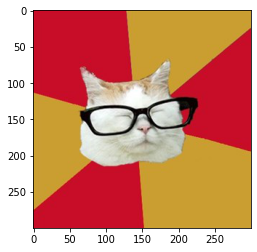

In [22]:
seen_path = random.choice(list(d_train.keys()))
pred_cap_seen = sample1Caption(seen_path, corpus, model, 1000)
gt_cap_seen = d_train[seen_path][:5]
imshow(Image.open(seen_path))
print(f"Some ground truth captions for this seen image: {gt_cap_seen}")
print(f"Caption sampled by fintuned CLIP for this seen image: {pred_cap_seen}")

Some ground truth captions for this unseen image: ['you shall not pass and login too', 'Angry Birds space Nice cats ctrl', 'Cowboy SheepGirl', 'Microsoft macrohard', 'Nightwish day disinclination']
Caption sampled by fintuned CLIP for this unseen image: IF GOD DOESN'T EXIST HOW COME A PIGEON IS TALKING TO YOU?


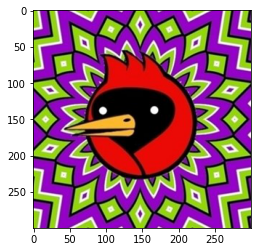

In [23]:
unseen_path = random.choice(list(d_test.keys()))
pred_cap_unseen = sample1Caption(unseen_path, corpus, model, 1000)
imshow(Image.open(unseen_path))
gt_cap_unseen = d_test[unseen_path][:5]
print(f"Some ground truth captions for this unseen image: {gt_cap_unseen}")
print(f"Caption sampled by fintuned CLIP for this unseen image: {pred_cap_unseen}")